# Credit Card Fraud Detection using Machine Learning

## Problem Statement
Credit card fraud detection is a highly imbalanced classification problem
where fraudulent transactions are extremely rare.

The objective of this project is to build and evaluate machine learning models
that can effectively identify fraudulent transactions while minimizing
false negatives.


In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix
)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


In [10]:
df = pd.read_csv('creditcard.csv')

In [11]:
df.sample(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
147835,89052.0,-0.589670,0.658766,1.096662,-0.618574,0.824410,-0.631514,1.275566,-0.401044,-0.284282,...,-0.291144,-0.681939,-0.267650,1.112941,0.619608,0.323171,-0.400761,-0.302570,36.55,0
29952,35712.0,1.293385,0.394850,-0.822564,0.541699,0.352173,-0.657328,0.151230,-0.013330,-0.084399,...,-0.161840,-0.531788,-0.171807,-0.634013,0.589556,0.408691,-0.050871,0.014142,0.76,0
84288,60238.0,-0.473843,0.721589,1.060954,0.098589,0.112787,-0.139173,0.573882,0.079977,0.231870,...,-0.044716,-0.105614,0.077611,-0.060354,-1.048225,-0.919488,0.007411,0.208512,29.99,0
274555,166082.0,-1.230138,1.259658,0.949962,-0.559040,-0.702416,0.058308,-1.176787,-2.103430,-0.127986,...,-0.899390,1.407903,-0.031021,0.021900,-0.263925,0.625149,-0.053051,0.110281,8.99,0


## Dataset Overview
- Dataset contains anonymized transaction features (`V1`–`V28`)
- `Amount` represents transaction value
- `Class` is the target variable:
  - `0` → Legitimate transaction
  - `1` → Fraudulent transaction


In [12]:
df.isnull().sum().sort_values()[:6]

Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
dtype: int64

## Data Cleaning
Duplicate transactions were identified and removed to prevent bias
during model training.


In [13]:
initial_duplicates = df.duplicated().sum()
print(f"Initial duplicate count: {initial_duplicates}")

df = df.drop_duplicates()

final_duplicates = df.duplicated().sum()
print(f"Final duplicate count: {final_duplicates}")


Initial duplicate count: 1081
Final duplicate count: 0


## Feature Engineering
The transaction amount was log-transformed to reduce skewness
and improve model stability.


In [16]:
X = df.drop('Class', axis=1)
y = df['Class']
X['Amount'] = np.log1p(X['Amount'])


## Train-Test Split

Stratified splitting was used to preserve the class imbalance
distribution in both training and test sets.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


## Model Training Strategy

Three approaches were evaluated:
1. Logistic Regression without resampling
2. Logistic Regression with class weighting
3. Logistic Regression with SMOTE oversampling

Pipelines were used to ensure proper scaling and prevent data leakage.


In [18]:
pipe_no_resample = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

pipe_no_resample.fit(X_train, y_train)

y_proba_nr = pipe_no_resample.predict_proba(X_test)[:, 1]
y_pred_nr = (y_proba_nr > 0.5).astype(int)


In [19]:
pipe_class_weight = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000
    ))
])

pipe_class_weight.fit(X_train, y_train)

y_proba_cw = pipe_class_weight.predict_proba(X_test)[:, 1]
y_pred_cw = (y_proba_cw > 0.5).astype(int)


In [20]:
pipe_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=27)),
    ('model', LogisticRegression(max_iter=1000))
])

pipe_smote.fit(X_train, y_train)

y_proba_sm = pipe_smote.predict_proba(X_test)[:, 1]
y_pred_sm = (y_proba_sm > 0.5).astype(int)


## Model Evaluation Metrics

Due to extreme class imbalance, accuracy is not a reliable metric.
The following metrics were used instead:
- Precision
- Recall
- F1-score
- ROC-AUC
- Precision-Recall AUC


In [21]:
def evaluate_model(y_true, y_pred, y_proba):
    return {
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "PR_AUC": average_precision_score(y_true, y_proba)
    }


In [22]:
results = pd.DataFrame.from_dict({
    "No Resampling": evaluate_model(y_test, y_pred_nr, y_proba_nr),
    "Class Weight": evaluate_model(y_test, y_pred_cw, y_proba_cw),
    "SMOTE": evaluate_model(y_test, y_pred_sm, y_proba_sm)
}, orient='index')

results


,Precision,Recall,F1,ROC_AUC,PR_AUC
No Resampling,0.848485,0.589474,0.695652,0.953157,0.701044
Class Weight,0.055407,0.873684,0.104206,0.962519,0.677019
SMOTE,0.052565,0.873684,0.099164,0.958911,0.683323


Class weighting and SMOTE significantly improved recall,
which is critical in fraud detection where missing fraudulent
transactions is costly.


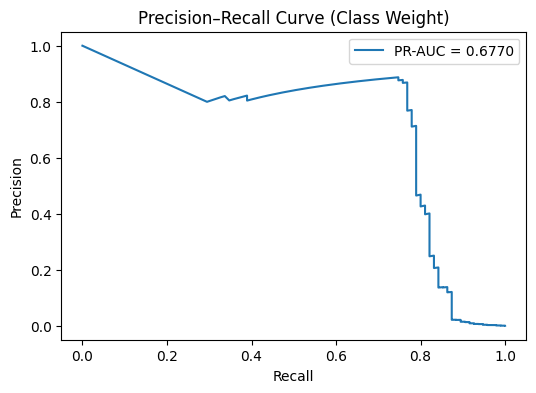

In [24]:
precision, recall, _ = precision_recall_curve(y_test, y_proba_cw)
pr_auc = average_precision_score(y_test, y_proba_cw)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Class Weight)")
plt.legend()
plt.show()


## Threshold Tuning

Instead of using the default threshold (0.5),
a lower threshold was tested to improve recall.


In [25]:
threshold = 0.3
y_pred_thresh = (y_proba_cw > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_thresh)
cm


array([[53539,  3112],
       [   12,    83]])

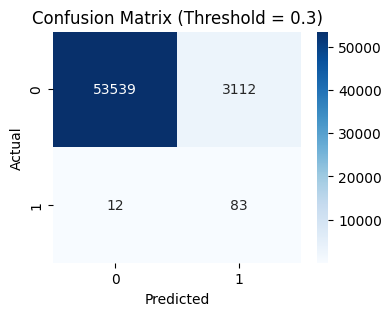

In [26]:
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.3)")
plt.show()


## Conclusion

- Fraud detection is a highly imbalanced classification problem.
- Class weighting and SMOTE significantly improved recall.
- Precision–Recall AUC proved more informative than accuracy.
- Threshold tuning allowed better control over recall–precision tradeoff.
- This project demonstrates real-world handling of imbalanced data
  using industry-standard techniques.
